# Lee-Carter per cause

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

## Data inladen

In [2]:
MYwd= os.getcwd()
file_path = MYwd+r"\Data\cause_specific_Short_Reconstructed\USA_m_short_idr.csv"       #short list
#file_path = MYwd+r"\Data\cause_specific_Interm_Reconstructed\USA_m_interm_idr.csv"    # intermediate list
#file_path = MYwd+r"\Data\cause_specific_Long_Reconstructed\USA_m_long_idr.csv"        # long list

data = pd.read_csv(file_path)

# deel door 1,000,000 om force of mortality te krijgen
exclude_cols = ['country', 'year', 'sex', 'list', 'agf', 'cause']
data.loc[:, ~data.columns.isin(exclude_cols)] = data.loc[:, ~data.columns.isin(exclude_cols)] / 1000000

# only keep the lines for both sexes: 
subset = data[data['sex'] == 3]
subset = subset.drop(columns=['sex', 'list', 'agf', 'total', 'm85p', 'm90p', 'm95p'])

# nu staat de data in de vorm: country, year, cause, m0, m1, m5, ...
# ik wil de vorm: country, year, cause, age, m

df = subset.melt(id_vars=['country', 'year', 'cause'], var_name='age', value_name='m')
df['age'] = df['age'].str.extract('(\d+)').astype(int)                           # Convert 'age' from 'mX' format to just 'X'
df['log_m'] = np.log(df['m'].replace(0,1e-8))                                    # add log mortality, avoid taking log(0)

df

,country,year,cause,age,m,log_m
0,USA,1979,S000,0,0.013268,-4.322410
1,USA,1979,S001,0,0.000238,-8.344846
2,USA,1979,S002,0,0.000051,-9.893359
3,USA,1979,S003,0,0.000046,-9.980239
4,USA,1979,S004,0,0.000116,-9.059380
...,...,...,...,...,...,...
16077,USA,2021,S012,100,0.007728,-4.862847
16078,USA,2021,S013,100,0.003336,-5.703083
16079,USA,2021,S014,100,0.009909,-4.614268
16080,USA,2021,S015,100,0.000122,-9.012154


## Functions to fit Lee-Carter

In [3]:
def fit_LC(df, correct_format = True):
    """This function fits the Lee-Carter model to the given dataframe df
    The dataframe needs a column with ages: Age, a column with years: Year and a column with log mortality rates: log_mortality
    The function returns the parameter estimates ax, bx and kt"""
    
    if not correct_format:
        # set data frame in the correct format (rows: ages, columns:years, values: log mortality)
        df = df.pivot(index='age', columns='year', values='log_m')
    
    ages = np.array(df.index)
    years = np.array(df.columns)
    
    # Estimate a_x
    ax = df.mean(axis=1)
    
    # Create the Z matrix: Z = ln(m_x,t) - ax = bx * kt
    Z = df.sub(ax, axis=0)
    
    # Perform SVD
    U, s, Vt = np.linalg.svd(Z.values, full_matrices=False)
    
    # Extract estimates for bx and kt
    bx = -U[:, 0]
    kt = -s[0] * Vt[0, :]
    
    # Satisfy constraints on parameters
    bx = bx / np.sum(bx)
    kt = (kt - np.mean(kt)) * sum(bx)
    ax = ax + bx * np.mean(kt)
    
    bx_series = pd.Series(bx, index=ages)
    kt_series = pd.Series(kt, index=years)
    ax_series = pd.Series(ax, index=ages)
    
    # Construct estimates for log_mortality = ax + bx * kt
    estimates = pd.DataFrame(index=ages, columns=years)

    for year in years:
        estimates[year] = ax_series + bx_series * kt_series[year]
    
    return ax, bx, kt, estimates

In [4]:
def forecast_LC(ax, bx, kt, forecast_years):
    """Given the fitted values for ax, bx and kt, this function calculates forecasts for the forecast_years"""

    # Fit ARIMA model on kt
    model = ARIMA(kt, order=(1,1,0))
    fit = model.fit()
    
    # Check convergence
    converged = fit.mle_retvals.get('converged')

    # Forecast 
    kt_forecast = fit.forecast(steps=len(forecast_years))
    kt_forecast = pd.Series(kt_forecast, index=forecast_years)
    
    # Construct forecasted matrix
    ages = np.array(ax.index)
    forecast_matrix = pd.DataFrame(index=ages, columns=forecast_years)

    for year in forecast_years:
        forecast_matrix[year] = ax + bx * kt_forecast[year]
    
    return forecast_matrix, converged

In [5]:
 # Set up the training set
train = df[(df['year'].between(1979, 2011))].copy()


test = df[(df['year'].between(2012, 2021))].copy()



#### Remove covid years from test set (! short list)
cause 10: 2020 and 2021 --> data is replaced by the data of 2019


In [6]:
ncauses = len(train['cause'].drop_duplicates())

if ncauses == 17:    # this only holds for the short list
    cause10_2019 = test[(test['cause'] == 'S010') & (test['year'] == 2019)]['log_m'].values

    # replace data in 2020 and 2021 by the data of 2019
    test.loc[(test['cause'] == 'S010') & (test['year'] == 2020), 'log_m'] = cause10_2019
    test.loc[(test['cause'] == 'S010') & (test['year'] == 2021), 'log_m'] = cause10_2019
    
    #covid = test[(test['cause'] == 'S010')]
    #plt.scatter(covid['age'], covid['log_m'])
    


C:\Users\liesv\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA model did not converge for cause S008; results may be unrealistic


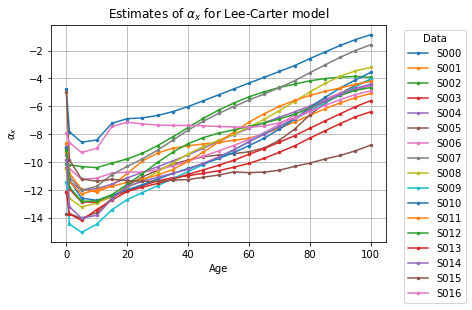

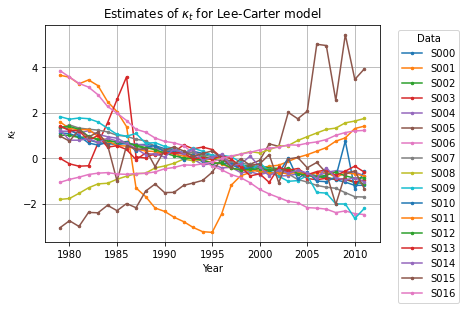

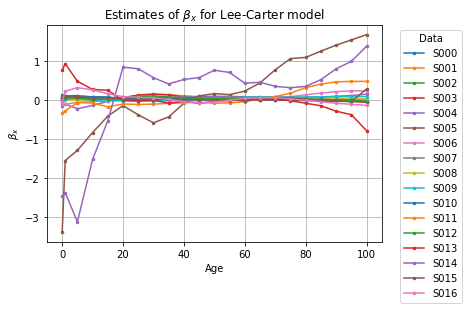

In [7]:
causes = train['cause'].drop_duplicates()

predic_results = pd.DataFrame(columns=['cause', 'year', 'age', 'predic_lnm'])

for cause in causes:
    train_set = train[train['cause'] == cause]
    test_set = test[test['cause'] == cause]
    
    # Fit Lee-Carter model:
    matrix = train_set.pivot(index='age', columns='year', values='log_m')
        
    ax, bx, kt, estimates = fit_LC(matrix)
        
    ages = np.array(matrix.index)
    years = np.array(matrix.columns)
    
    # Nice plots of the estimates
    plt.figure(1)
    plt.plot(ages, ax, marker='.', markersize=5, label=f'{cause}')
    plt.xlabel('Age')
    plt.ylabel(r'$\alpha_x$')
    plt.grid()
    plt.title(r'Estimates of $\alpha_x$ for Lee-Carter model')
    plt.legend(bbox_to_anchor=(1.04, 1), title="Data")
        
    plt.figure(2)
    plt.plot(years, kt, marker='.', markersize=5, label=f'{cause}')
    plt.xlabel('Year')
    plt.ylabel(r'$\kappa_t$')
    plt.grid()
    plt.title(r'Estimates of $\kappa_t$ for Lee-Carter model')
    plt.legend(bbox_to_anchor=(1.04, 1), title="Data")
        
    plt.figure(3)
    plt.plot(ages, bx, marker='.', markersize=5, label=f'{cause}')
    plt.xlabel('Age')
    plt.ylabel(r'$\beta_x$')
    plt.grid()
    plt.title(r'Estimates of $\beta_x$ for Lee-Carter model')
    plt.legend(bbox_to_anchor=(1.04, 1), title="Data")
    
    # Compute forecasts
    forecast_years = test_set['year'].drop_duplicates()
    
    forecast_matrix, converged = forecast_LC(ax, bx, kt, forecast_years)
    if not converged: 
        print(f'ARIMA model did not converge for cause {cause}; results may be unrealistic')
    
    forecast_df = forecast_matrix.reset_index().melt(id_vars='index', var_name='year', value_name='predic_lnm')
    forecast_df.rename(columns={'index':'age'}, inplace=True)
    forecast_df['cause'] = cause
    
    predic_results = pd.concat([predic_results, forecast_df], ignore_index=True)

In [8]:

results = pd.merge(test, predic_results, on=['cause', 'year', 'age'], how='left')

results

,country,year,cause,age,m,log_m,predic_lnm
0,USA,2012,S000,0,0.006014,-5.113698,-4.861952
1,USA,2012,S001,0,0.000151,-8.800445,-8.626269
2,USA,2012,S002,0,0.000031,-10.373523,-10.192079
3,USA,2012,S003,0,0.000020,-10.831396,-10.450866
4,USA,2012,S004,0,0.000045,-9.999734,-9.391404
...,...,...,...,...,...,...,...
3735,USA,2021,S012,100,0.007728,-4.862847,-4.626219
3736,USA,2021,S013,100,0.003336,-5.703083,-5.174572
3737,USA,2021,S014,100,0.009909,-4.614268,-5.758033
3738,USA,2021,S015,100,0.000122,-9.012154,-9.095936


In [15]:
# Save to excel
#results.to_excel('predictions_LC_Short.xlsx', index=False)

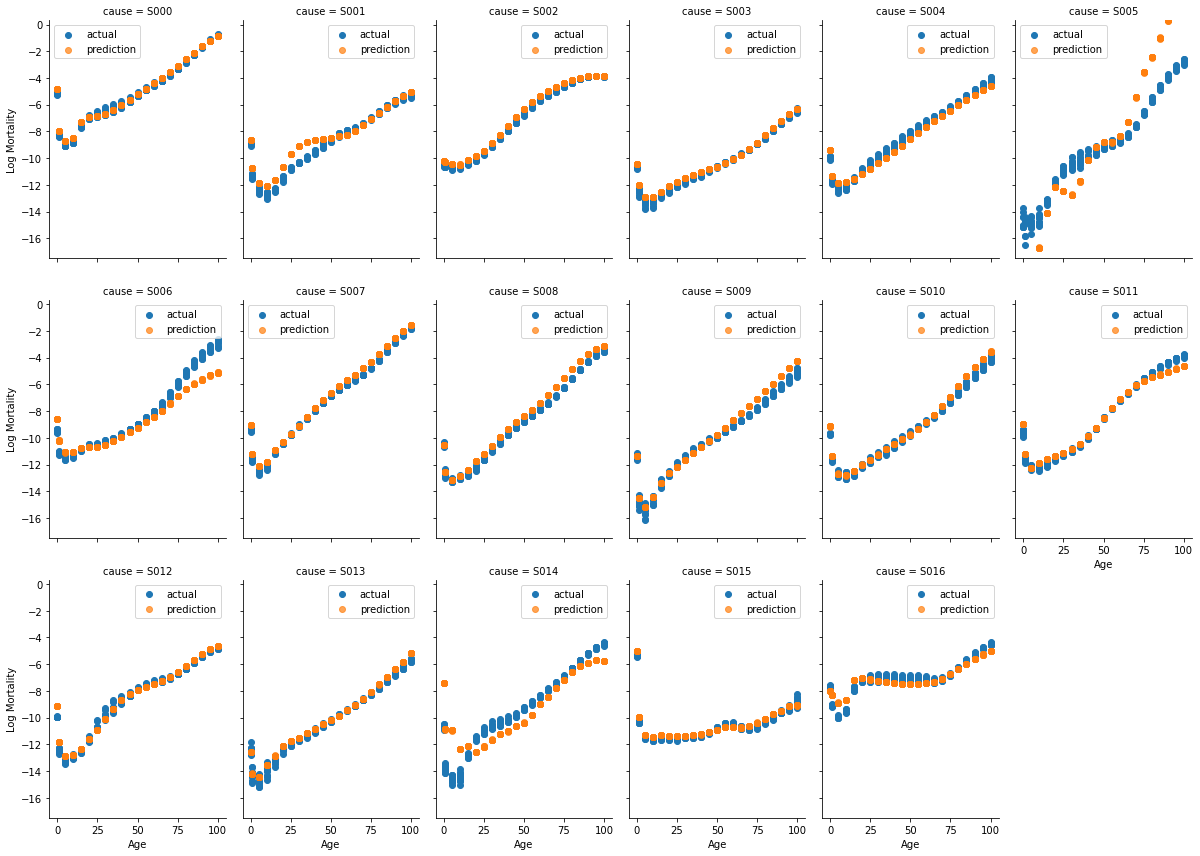

In [10]:
# goodness of fit on plot
g = sns.FacetGrid(results, col='cause', palette='mako',
                  margin_titles=True, height=4, aspect=0.7, col_wrap=6)

g.map(sns.scatterplot, 'age', 'log_m', s=20)

# Adjust the title, legend, and axis formatting
g.set_axis_labels("Age", "Log Mortality")

ymin, ymax = results['log_m'].min(), results['log_m'].max()

# Apply the same y-axis limits to all subplots
g.set(ylim=(ymin-1, ymax+1))


for ax, (_, subset) in zip(g.axes.flat, results.groupby(['cause'])):
    scatter = ax.scatter(subset['age'], subset['log_m'], label='actual')
    ax.scatter(subset['age'], subset['predic_lnm'], label='prediction', alpha=0.7)
    ax.legend()

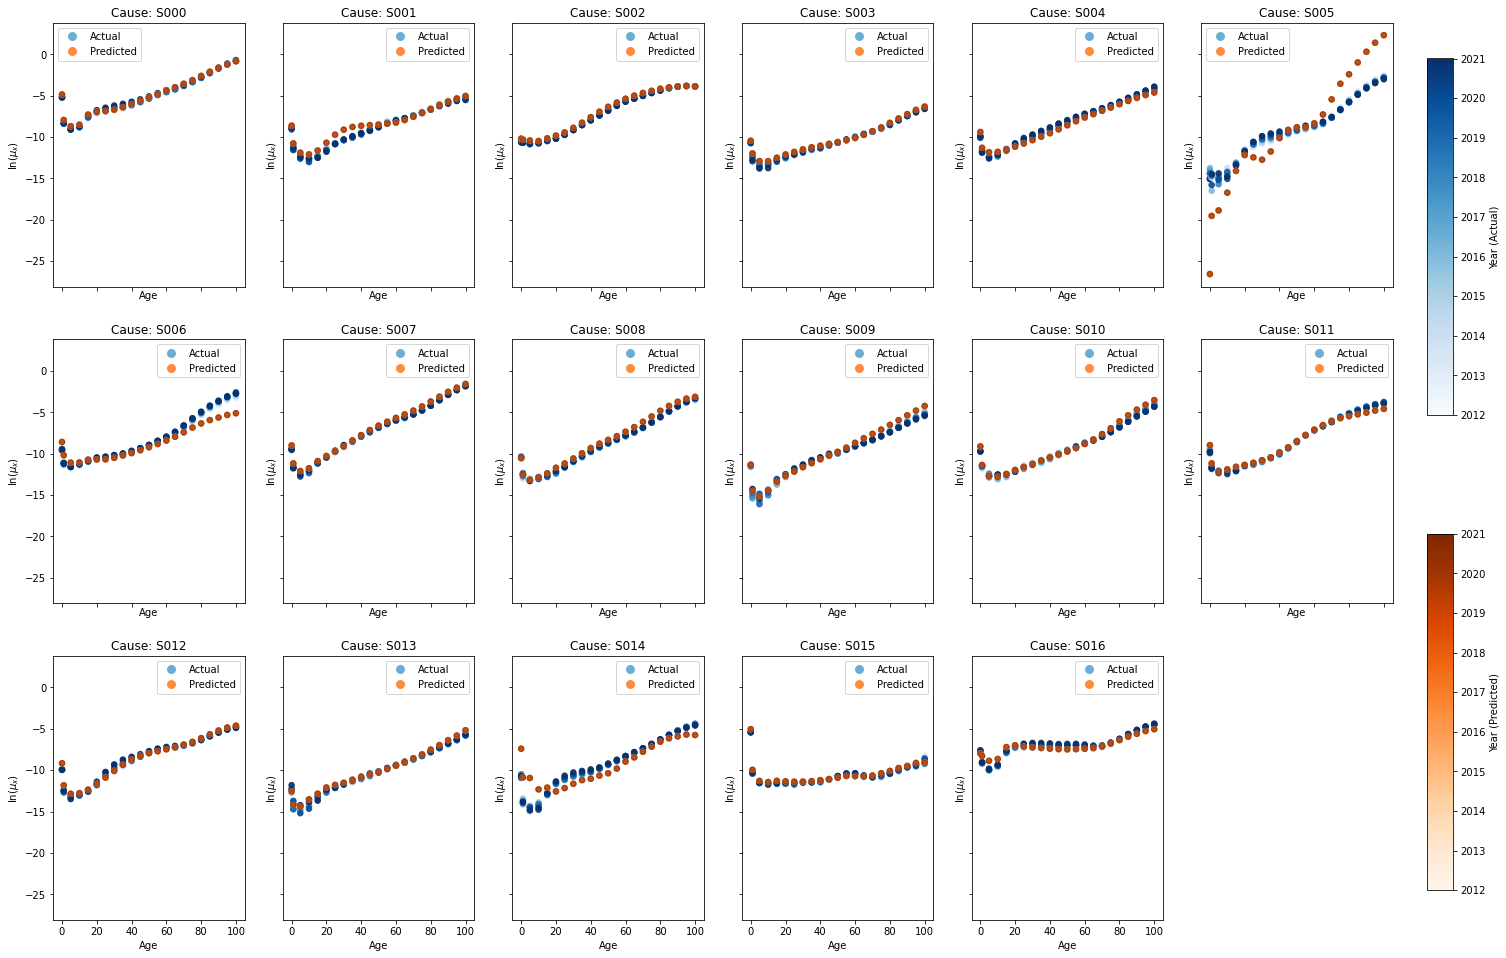

In [11]:
### Mooier plotje (danku chatgpt) ###
#####################################

# Unique causes and color normalization
causes = results['cause'].unique()
num_causes = len(causes)

# Set up grid
cols = 6
rows = int(np.ceil(num_causes / cols))
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4 * cols, 5.5 * rows), sharex=True, sharey=True)
axes = axes.flatten()

# Color maps
cmap_blue = sns.color_palette("Blues", as_cmap=True)
cmap_red = sns.color_palette("Oranges", as_cmap=True)
year_min, year_max = results['year'].min(), results['year'].max()
norm = plt.Normalize(year_min, year_max)

# Plotting loop
for ax, cause in zip(axes, causes):
    cause_data = results[results['cause'] == cause]

    # Actual values
    ax.scatter(cause_data['age'], cause_data['log_m'],
               c=[cmap_blue(norm(y)) for y in cause_data['year']],
               s=30, alpha=0.9,label='Actual')

    # Predicted values
    ax.scatter(cause_data['age'], cause_data['predic_lnm'],
               c=[cmap_red(norm(y)) for y in cause_data['year']],
               s=30, alpha=0.3, label='Predicted')

    ax.set_title(f"Cause: {cause}")
    ax.set_xlabel("Age")
    ax.set_ylabel(r"$\ln(\mu_x)$")
    ax.legend(loc='upper right')
    
    legend_markers = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_blue(norm((year_max+year_min)/2)), markersize=10, label="Actual"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap_red(norm((year_max+year_min)/2)), markersize=10, label="Predicted")
    ]
    ax.legend(handles=legend_markers)

# Remove extra axes
for i in range(len(causes), len(axes)):
    fig.delaxes(axes[i])

# Colorbars
cbar_ax_blue = fig.add_axes([0.92, 0.55, 0.015, 0.3])
sm_blue = plt.cm.ScalarMappable(cmap=cmap_blue, norm=norm)
fig.colorbar(sm_blue, cax=cbar_ax_blue, label="Year (Actual)")

cbar_ax_red = fig.add_axes([0.92, 0.15, 0.015, 0.3])
sm_red = plt.cm.ScalarMappable(cmap=cmap_red, norm=norm)
fig.colorbar(sm_red, cax=cbar_ax_red, label="Year (Predicted)")

plt.show()

In [12]:
overall_mse = mean_squared_error(results['log_m'], results['predic_lnm'])

print(f'Overall mse: {overall_mse}')

mse_df = pd.DataFrame(columns=['Cause', 'mse_lc'])
index = 0

for cause in causes:
    
    subset = results[results['cause'] == cause]
    mse = mean_squared_error(subset['log_m'], subset['predic_lnm'])
    
    mse_df.loc[index] = [cause, mse]
    index += 1

mse_df

Overall mse: 1.1011247311283558


,Cause,mse_lc
0,S000,0.044366
1,S001,0.358853
2,S002,0.066854
3,S003,0.068709
4,S004,0.132341
5,S005,13.569023
6,S006,0.924985
7,S007,0.106036
8,S008,0.229404
9,S009,0.262016


In [13]:
mses = mse_df['mse_lc']

maxi = max(mses)
maxi

mses = mses[mses != maxi]
mses

mses.mean()

0.3218810672103389

In [16]:
#mse_df.to_excel("mse_LC.xlsx", index=False)